# 生成式对抗网络

<!-- [![在线运行](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/r1.7/resource/_static/logo_modelarts.png)](https://authoring-modelarts-cnnorth4.huaweicloud.com/console/lab?share-url-b64=aHR0cHM6Ly9vYnMuZHVhbHN0YWNrLmNuLW5vcnRoLTQubXlodWF3ZWljbG91ZC5jb20vbWluZHNwb3JlLXdlYnNpdGUvbm90ZWJvb2svcjEuNy90dXRvcmlhbHMvYXBwbGljYXRpb24vemhfY24vY3YvbWluZHNwb3JlX2RjZ2FuLmlweW5i&imageid=9d63f4d1-dc09-4873-b669-3483cea777c0)&emsp;[![下载Notebook](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/r1.7/resource/_static/logo_notebook.png)](https://obs.dualstack.cn-north-4.myhuaweicloud.com/mindspore-website/notebook/r1.7/tutorials/application/zh_cn/cv/mindspore_dcgan.ipynb)&emsp;[![下载样例代码](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/r1.7/resource/_static/logo_download_code.png)](https://obs.dualstack.cn-north-4.myhuaweicloud.com/mindspore-website/notebook/r1.7/tutorials/application/zh_cn/cv/mindspore_dcgan.py)&emsp;[![查看源文件](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/r1.7/resource/_static/logo_source.png)](https://gitee.com/mindspore/docs/blob/r1.7/tutorials/application/source_zh_cn/cv/dcgan.ipynb) -->

## GAN基础原理

生成式对抗网络（Generative Adversarial Networks，GAN）是一种深度学习模型，是近年来复杂分布上无监督学习最具前景的方法之一。

最初，GAN由Ian J. Goodfellow于2014年发明，并在论文[Generative Adversarial Nets](https://papers.nips.cc/paper/5423-generative-adversarial-nets.pdf)中首次进行了描述，GAN由两个不同的模型组成——**生成器**和**判别器**：

- 生成器的任务是生成看起来像训练图像的“假”图像；
- 判别器需要判断从生成器输出的图像是真实的训练图像还是虚假的图像。

在训练过程中，生成器会不断尝试通过生成更好的假图像来骗过判别器，而判别器在这过程中也会逐步提升判别能力。这种博弈的平衡点是，当生成器生成的假图像和训练数据图像的分布完全一致时，判别器拥有50%的真假判断置信度。下面，我们首先定义一些在整个过程中需要用到的符号：

判别器的表示

- $x$：代表图像数据；
- $D(x)$：判别器网络，给出图像判定为真实图像的概率；

在判别过程中，$D(x)$需要处理CHW格式且大小为3x64x64的图像数据。当$x$来自训练数据时，$D(x)$数值应该趋近于1，而当$x$来自生成器时，$D(x)$数值应该趋近于0。因此$D(x)$也可以被认为是传统的二分类器。

生成器的表示

- $z$：标准正态分布中提取出的隐向量；
- $G(z)$：表示将隐向量$z$映射到数据空间的生成器函数；

函数$G(z)$的目标是将一个随机高斯噪声$z$通过一个生成网络生成一个和真实数据分布$pdata(x)$差不多的数据分布，其中$θ$是网络参数，我们希望找到$θ$使得$pG(x;θ)$和$pdata(x)$尽可能的接近。

$D(G(z))$是生成器$G$生成的假图像被判定为真实图像的概率，如[Goodfellow 的论文](https://papers.nips.cc/paper/5423-generative-adversarial-nets.pdf)中所述，`D`和`G`在进行一场博弈，`D`想要最大程度的正确分类真图像与假图像，也就是参数$log D(x)$；而`G`试图欺骗`D`来最小化假图像被识别到的概率，也就是参数$log(1−D(G(z)))$。GAN的损失函数为：

$$\min_{G}\max_{D}V(D,G)=E_{x\sim_Pdata(x)}[log(D(x))]+E_{z\sim_Pz(z)}[log(1-D(G(z)))]$$

从理论上讲，此博弈游戏的平衡点是$pG(x;θ) = pdata(x)$，此时判别器会随机猜测输入是真图像还是假图像。下面我们简要说明生成器和判别器的博弈过程：

![gan](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/r1.7/tutorials/application/source_zh_cn/cv/images/gan_image.png)

在上图中，蓝色虚线表示判别器，黑色虚线表示真实数据分布，绿色实线表示生成器生成的虚假数据分布，z表示隐向量，x表示生成的虚假图像G(z)。

1. 在训练刚开始的时候，生成器和判别器的质量都比较差，生成器会随机生成一个数据分布。
2. 判别器通过求取梯度和损失函数对网络进行优化，将靠近真实数据分布的数据判定为1，将靠近生成器生成出来数据分布的数据判定为0。
3. 生成器通过优化，生成出更加贴近真实数据分布的数据。
4. 生成器所生成的数据和真实数据达到相同的分布，此时判别器的输出为1/2。

## DCGAN

DCGAN（深度卷积对抗生成网络，Deep Convolutional Generative Adversarial Networks）是GAN的直接扩展。不同之处在于，DCGAN会分别在判别器和生成器中使用卷积和转置卷积层。

它最早由Radford等人在论文[Unsupervised Representation Learning With Deep Convolutional Generative Adversarial Networks](https://arxiv.org/pdf/1511.06434.pdf)中进行描述。判别器由分层的卷积层、BatchNorm层和LeakyReLU激活层组成。输入是3x64x64的图像，输出是该图像为真图像的概率。生成器则是由转置卷积层、BatchNorm层和ReLU激活层组成。输入是标准正态分布中提取出的隐向量$z$，输出是3x64x64的RGB图像。

# DCGAN实践
在此次实践中，我更换了原来案例提供的faces数据集，更换成了kaggle上的[Human Faces Revised](https://www.kaggle.com/datasets/tposisme/human-faces-revised)和[Animal Faces](https://www.kaggle.com/datasets/andrewmvd/animal-faces)数据集；尝试修改了超参数，并对网络结构做了修改。

在下面的实例中，我使用的数据集是来自kaggle的[Animal Faces](https://www.kaggle.com/datasets/andrewmvd/animal-faces)数据集，该数据集中总共包含有16,130张高清动物面部图片，分为三个部分，分别是cat，dog，wild，我选取的是cat类，总共有4834张。

在原有网络参数的基础之上，我调节了隐向量维数（100->150），更改了训练epoch次数，并对原有网络结构做了修改，在生成器和判别器中分别增加了一层卷积层。

训练效果在后文中有显示



下载后的数据集目录结构如下：
```text
./animal_datasets
├──train_cat
    ├──flickrcat000001.jpg
    ├──flickrcat000002.jpg
    ...
    ├──flickrcat0004834.jpg
├──train_dog
    ├──flickrdog000001.jpg
    ├──flickrdog000002.jpg
    ...
    ├──flickrdog0004834.jpg
├──train_wild
    ├──flickrwild000001.jpg
    ├──flickrwild000002.jpg
    ...
    ├──flickrwild0004834.jpg
```
该数据集较大且结构不满足案例提供的create_dataset_imagenet()函数处理结构，需要对该数据集结构进行调整，并只选出cat类作为最终的数据集



In [ ]:
import shutil
import os

def remove_file(old_path, new_path):
    print(old_path)
    print(new_path)
    filelist = os.listdir(old_path) #列出该目录下的所有文件,listdir返回的文件列表是不包含路径的。
    print(filelist)
    for file in filelist:
        src = os.path.join(old_path, file)
        dst = os.path.join(new_path, file)
        print('src:', src)
        print('dst:', dst)
        shutil.move(src, dst)

remove_file(r"./animal_datasets/train_cats",r"./cat_datasets/train_cat/")

变换后的数据集结构如下：
```text
./cat_datasets/train_cat
├── flickrcat000001.jpg
├── flickrcat000001.jpg
├── flickrcat000002.jpg
├── flickrcat000003.jpg
├── flickrcat000004.jpg
    ...
├── flickrcat000004833.jpg
└── flickrcat000004834.jpg
```

### 数据处理

首先为执行过程定义一些输入：

In [2]:
from mindspore import context

# 选择执行模式为图模式；指定训练使用的平台为"GPU"，如需使用昇腾硬件可将其替换为"Ascend"
context.set_context(mode=context.GRAPH_MODE, device_target="GPU")
# context.set_context(device_id=0)

data_root = "./cat_datasets"  # 数据集根目录
workers = 4  # 载入数据线程数
batch_size = 128  # 批量大小
image_size = 64  # 训练图像空间大小，所有图像都将调整为该大小
nc = 3  # 图像彩色通道数，对于彩色图像为3
nz = 150  # 隐向量的长度
ngf = 64  # 特征图在生成器中的大小
ndf = 64  # 特征图在判别器中的大小
num_epochs = 100  # 训练周期数
lr = 0.0002  # 学习率
beta1 = 0.5  # Adam优化器的beta1超参数

定义`create_dataset_imagenet`函数对数据进行处理和增强操作。

In [3]:
import numpy as np
import mindspore.dataset as ds
import mindspore.dataset.vision.c_transforms as vision

from mindspore import nn, ops, Tensor
from mindspore import dtype as mstype

def create_dataset_imagenet(dataset_path, num_parallel_workers=None):
    """数据加载"""
    data_set = ds.ImageFolderDataset(dataset_path, num_parallel_workers=num_parallel_workers, shuffle=True,
                                     decode=True)

    # 数据增强操作
    transform_img = [
        vision.Resize(image_size),
        vision.CenterCrop(image_size),
        vision.HWC2CHW(),
        lambda x: ((x / 255).astype("float32"), np.random.normal(size=(nz, 1, 1)).astype("float32"))
    ]

    # 数据映射操作
    data_set = data_set.map(input_columns="image", num_parallel_workers=num_parallel_workers, operations=transform_img,
                            output_columns=["image", "latent_code"], column_order=["image", "latent_code"])

    # 批量操作
    data_set = data_set.batch(batch_size)
    return data_set

# 获取处理后的数据集
data = create_dataset_imagenet(data_root, num_parallel_workers=workers)

# 获取数据集大小
size = data.get_dataset_size()

通过`create_dict_iterator`函数将数据转换成字典迭代器，然后使用`matplotlib`模块可视化部分训练数据。

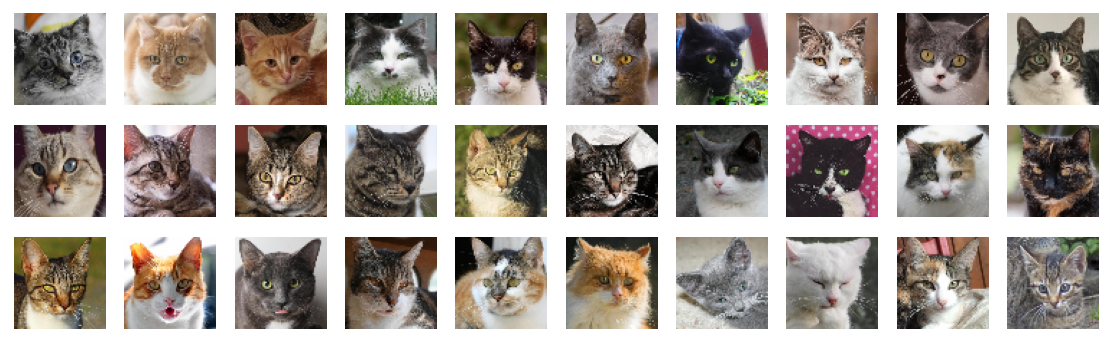

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

data_iter = next(data.create_dict_iterator(output_numpy=True))

# 可视化部分训练数据
plt.figure(figsize=(10, 3), dpi=140)
for i, image in enumerate(data_iter['image'][:30], 1):
    plt.subplot(3, 10, i)
    plt.axis("off")
    plt.imshow(image.transpose(1, 2, 0))
plt.show()

### 创建网络

当处理完数据后，就可以来进行网络的搭建了。按照DCGAN论文中的描述，所有模型权重均应从`mean`为0，`sigma`为0.02的正态分布中随机初始化。

#### 生成器

生成器`G`的功能是将隐向量`z`映射到数据空间。由于数据是图像，这一过程也会创建与真实图像大小相同的 RGB 图像。在实践场景中，该功能是通过一系列`Conv2dTranspose`转置卷积层来完成的，每个层都与`BatchNorm2d`层和`ReLu`激活层配对，输出数据会经过`tanh`函数，使其返回`[-1,1]`的数据范围内。

DCGAN论文生成图像如下所示：

![dcgangenerator](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/r1.7/tutorials/application/source_zh_cn/cv/images/dcgan.png)

> 图片来源 https://arxiv.org/pdf/1511.06434.pdf

通过输入部分中设置的`nz`、`ngf`和`nc`来影响代码中的生成器结构。`nz`是隐向量`z`的长度，`ngf`与通过生成器传播的特征图的大小有关，`nc`是输出图像中的通道数。

原本打算增加生成器网络深度，在每一层后面都增加一层卷积层，但是在运行后出现显存溢出的错误，所以只在隐向量后增加了一层卷积层

以下是生成器的代码实现：

In [5]:
from mindspore.common.initializer import Normal

def conv_t(in_channels, out_channels, kernel_size, stride=1, padding=0, pad_mode="pad"):
    """定义转置卷积层"""
    weight_init = Normal(mean=0, sigma=0.02)
    return nn.Conv2dTranspose(in_channels, out_channels,
                              kernel_size=kernel_size, stride=stride, padding=padding,
                              weight_init=weight_init, has_bias=False, pad_mode=pad_mode)

def bn(num_features):
    """定义BatchNorm2d层"""
    gamma_init = Normal(mean=1, sigma=0.02)
    return nn.BatchNorm2d(num_features=num_features, gamma_init=gamma_init)

class Generator(nn.Cell):
    """DCGAN网络生成器"""

    def __init__(self):
        super(Generator, self).__init__()
        self.generator = nn.SequentialCell()
        # self.generator.append(conv_t(nz, ngf * 8, 4, 1, 0))
        # self.generator.append(bn(ngf * 8))
        # self.generator.append(nn.ReLU())
        # self.generator.append(conv_t(ngf * 8, ngf * 4, 4, 2, 1))
        # self.generator.append(bn(ngf * 4))
        # self.generator.append(nn.ReLU())
        # self.generator.append(conv_t(ngf * 4, ngf * 2, 4, 2, 1))
        # self.generator.append(bn(ngf * 2))
        # self.generator.append(nn.ReLU())
        # self.generator.append(conv_t(ngf * 2, ngf, 4, 2, 1))
        # self.generator.append(bn(ngf))
        # self.generator.append(nn.ReLU())
        # self.generator.append(conv_t(ngf, nc, 4, 2, 1))
        # self.generator.append(nn.Tanh())
        
        #修改了网络结构，在隐向量后添加了一层1*1*100 -> 2*2*1024的卷积层
        self.generator.append(conv_t(nz, ngf * 16, 4, 2, 1)) # 1*1*100 -> 2*2*1024
        self.generator.append(bn(ngf * 16))
        self.generator.append(nn.ReLU())
        
        self.generator.append(conv_t(ngf * 16, ngf * 8, 4, 2, 1)) # 2*2*1024 -> 4*4*512
        self.generator.append(bn(ngf * 8))
        self.generator.append(nn.ReLU())

        self.generator.append(conv_t(ngf * 8, ngf * 4, 4, 2, 1)) # 4*4*512 -> 8*8*256
        self.generator.append(bn(ngf * 4))
        self.generator.append(nn.ReLU())

        self.generator.append(conv_t(ngf * 4, ngf * 2, 4, 2, 1)) # 8*8*256 -> 16*16*128
        self.generator.append(bn(ngf * 2))
        self.generator.append(nn.ReLU())

        self.generator.append(conv_t(ngf * 2, ngf, 4, 2, 1)) # 16*16*128 -> 32*32*64
        self.generator.append(bn(ngf))
        self.generator.append(nn.ReLU())

        self.generator.append(conv_t(ngf, nc, 4, 2, 1)) # 32*32*64 -> 64*64*3
        self.generator.append(nn.Tanh())

    def construct(self, x):
        return self.generator(x)

# 实例化生成器
netG = Generator()

#### 判别器

如前所述，判别器`D`是一个二分类网络模型，输出判定该图像为真实图的概率。通过一系列的`Conv2d`、`BatchNorm2d`和`LeakyReLU`层对其进行处理，最后通过`Sigmoid`激活函数得到最终概率。

DCGAN论文提到，使用卷积而不是通过池化来进行下采样是一个好方法，因为它可以让网络学习自己的池化特征。

同生成器类似，在最后一层前增加一层卷积层，先将512\*4\*4的特征图增加通道到1024\*2\*2，在输入到后一层卷积层中。由于输入的量为1024\*2\*2，无法使用4\*4的卷积核，所以将原来的卷积核修改为2\*2。

判别器的代码实现如下：

In [6]:
def conv(in_channels, out_channels, kernel_size, stride=1, padding=0, pad_mode="pad"):
    """定义卷积层"""
    weight_init = Normal(mean=0, sigma=0.02)
    return nn.Conv2d(in_channels, out_channels,
                     kernel_size=kernel_size, stride=stride, padding=padding,
                     weight_init=weight_init, has_bias=False, pad_mode=pad_mode)

class Discriminator(nn.Cell):
    """DCGAN网络判别器"""

    def __init__(self):
        super(Discriminator, self).__init__()
        self.discriminator = nn.SequentialCell()
        self.discriminator.append(conv(nc, ndf, 4, 2, 1)) #3*64 -> 64*32
        self.discriminator.append(nn.LeakyReLU(0.2))

        self.discriminator.append(conv(ndf, ndf * 2, 4, 2, 1)) # 64*32 -> 128*16
        self.discriminator.append(bn(ndf * 2))
        self.discriminator.append(nn.LeakyReLU(0.2))
        # self.discriminator.append(conv(ndf * 2, ndf * 2, 3, 1, 1)) # 128*16 -> 128*16
        # self.discriminator.append(bn(ndf * 2))
        # self.discriminator.append(nn.LeakyReLU(0.2))


        self.discriminator.append(conv(ndf * 2, ndf * 4, 4, 2, 1)) # 128*16 -> 256*8
        self.discriminator.append(bn(ndf * 4))
        self.discriminator.append(nn.LeakyReLU(0.2))
        # self.discriminator.append(conv(ndf * 4, ndf * 4, 3, 1, 1)) # 256*8 -> 256*8
        # self.discriminator.append(bn(ndf * 4))
        # self.discriminator.append(nn.LeakyReLU(0.2))


        self.discriminator.append(conv(ndf * 4, ndf * 8, 4, 2, 1)) # 256*8 -> 512*4
        self.discriminator.append(bn(ndf * 8))
        self.discriminator.append(nn.LeakyReLU(0.2))
        # self.discriminator.append(conv(ndf * 8, ndf * 8, 3, 1, 1)) # 512*4 -> 512*4
        # self.discriminator.append(bn(ndf * 8))
        # self.discriminator.append(nn.LeakyReLU(0.2))

        self.discriminator.append(conv(ndf * 8, ndf * 16, 4, 2, 1)) # 512*4 -> 1024*2
        self.discriminator.append(bn(ndf * 16))
        self.discriminator.append(nn.LeakyReLU(0.2))
        # self.discriminator.append(conv(ndf * 16, ndf * 16, 3, 1, 1)) # 1024*2 -> 1024*2
        # self.discriminator.append(bn(ndf * 16))
        # self.discriminator.append(nn.LeakyReLU(0.2))
        
        self.discriminator.append(conv(ndf * 16, 1, 2, 1)) # 1024*2 -> 1*1
        self.discriminator.append(nn.Sigmoid())

    def construct(self, x):
        return self.discriminator(x)

# 实例化判别器
netD = Discriminator()

### 连接网络和损失函数

MindSpore将损失函数、优化器等操作都封装到了Cell中，因为GAN结构上的特殊性，其损失是判别器和生成器的多输出形式，这就导致它和一般的分类网络不同。所以我们需要自定义`WithLossCell`类，将网络和Loss连接起来。

- 连接生成器和损失函数，代码如下：

In [7]:
class WithLossCellG(nn.Cell):
    """连接生成器和损失"""

    def __init__(self, netD, netG, loss_fn):
        super(WithLossCellG, self).__init__(auto_prefix=True)
        self.netD = netD
        self.netG = netG
        self.loss_fn = loss_fn

    def construct(self, latent_code):
        """构建生成器损失计算结构"""
        fake_data = self.netG(latent_code)
        out = self.netD(fake_data)
        label_real = ops.OnesLike()(out)
        loss = self.loss_fn(out, label_real)
        return loss

- 连接判别器和损失函数，代码如下：

In [8]:
class WithLossCellD(nn.Cell):
    """连接判别器和损失"""

    def __init__(self, netD, netG, loss_fn):
        super(WithLossCellD, self).__init__(auto_prefix=True)
        self.netD = netD
        self.netG = netG
        self.loss_fn = loss_fn

    def construct(self, real_data, latent_code):
        """构建判别器损失计算结构"""
        out_real = self.netD(real_data)
        label_real = ops.OnesLike()(out_real)
        loss_real = self.loss_fn(out_real, label_real)

        fake_data = self.netG(latent_code)
        fake_data = ops.stop_gradient(fake_data)
        out_fake = self.netD(fake_data)
        label_fake = ops.ZerosLike()(out_fake)
        loss_fake = self.loss_fn(out_fake, label_fake)
        return loss_real + loss_fake

### 损失函数和优化器

当定义了`D`和`G`后，接下来将使用MindSpore中定义的二进制交叉熵损失函数[BCELoss](https://www.mindspore.cn/docs/zh-CN/r1.7/api_python/nn/mindspore.nn.BCELoss.html)
，为`D`和`G`加上损失函数和优化器。

这里设置了两个单独的优化器，一个用于`D`，另一个用于`G`。这两个都是`lr = 0.0002`和`beta1 = 0.5`的Adam优化器。

为了跟踪生成器的学习进度，在训练的过程中，我们定期将一批固定的遵循高斯分布的隐向量`fixed_noise`输入到`G`中，可以看到隐向量生成的图像。

In [9]:
# 定义损失函数
criterion = nn.BCELoss(reduction='mean')

# 创建一批隐向量用来观察G
np.random.seed(1)
fixed_noise = Tensor(np.random.randn(64, nz, 1, 1), dtype=mstype.float32)

# 为生成器和判别器设置优化器
optimizerD = nn.Adam(netD.trainable_params(), learning_rate=lr, beta1=beta1)
optimizerG = nn.Adam(netG.trainable_params(), learning_rate=lr, beta1=beta1)

### 训练

训练分为两个主要部分：训练判别器和训练生成器。

- 训练判别器

   训练判别器的目的是最大程度地提高判别图像真伪的概率。按照Goodfellow的方法，是希望通过提高其随机梯度来更新判别器，所以我们要最大化$log D(x) + log(1 - D(G(z))$的值。

- 训练生成器

   如DCGAN论文所述，我们希望通过最小化$log(1 - D(G(z)))$来训练生成器，以产生更好的虚假图像。

在这两个部分中，分别获取训练过程中的损失，并在每个周期结束时进行统计，将`fixed_noise`批量推送到生成器中，以直观地跟踪`G`的训练进度。下面进行训练：

In [10]:
class DCGAN(nn.Cell):
    """定义DCGAN网络"""

    def __init__(self, myTrainOneStepCellForD, myTrainOneStepCellForG):
        super(DCGAN, self).__init__(auto_prefix=True)
        self.myTrainOneStepCellForD = myTrainOneStepCellForD
        self.myTrainOneStepCellForG = myTrainOneStepCellForG

    def construct(self, real_data, latent_code):
        output_D = self.myTrainOneStepCellForD(real_data, latent_code).view(-1)
        netD_loss = output_D.mean()
        output_G = self.myTrainOneStepCellForG(latent_code).view(-1)
        netG_loss = output_G.mean()
        return netD_loss, netG_loss

实例化生成器和判别器的`WithLossCell`和`TrainOneStepCell`。

In [11]:
# 实例化WithLossCell
netD_with_criterion = WithLossCellD(netD, netG, criterion)
netG_with_criterion = WithLossCellG(netD, netG, criterion)

# 实例化TrainOneStepCell
myTrainOneStepCellForD = nn.TrainOneStepCell(netD_with_criterion, optimizerD)
myTrainOneStepCellForG = nn.TrainOneStepCell(netG_with_criterion, optimizerG)

循环训练网络，每经过50次迭代，就收集生成器和判别器的损失，以便于后面绘制训练过程中损失函数的图像。

In [12]:
from mindspore import save_checkpoint

# 实例化DCGAN网络
dcgan = DCGAN(myTrainOneStepCellForD, myTrainOneStepCellForG)
dcgan.set_train()

# 创建迭代器
data_loader = data.create_dict_iterator(output_numpy=True, num_epochs=num_epochs)
G_losses = []
D_losses = []
image_list = []

# 开始循环训练
print("Starting Training Loop...")

for epoch in range(num_epochs):
    # 为每轮训练读入数据
    for i, d in enumerate(data_loader):
        real_data = Tensor(d['image'])
        latent_code = Tensor(d["latent_code"])
        netD_loss, netG_loss = dcgan(real_data, latent_code)
        if i % 50 == 0 or i == size - 1:
            # 输出训练记录
            print('[%2d/%d][%3d/%d]   Loss_D:%7.4f  Loss_G:%7.4f' % (
                epoch + 1, num_epochs, i + 1, size, netD_loss.asnumpy(), netG_loss.asnumpy()))
        D_losses.append(netD_loss.asnumpy())
        G_losses.append(netG_loss.asnumpy())

    # 每个epoch结束后，使用生成器生成一组图片
    img = netG(fixed_noise)
    image_list.append(img.transpose(0, 2, 3, 1).asnumpy())

    # 保存网络模型参数为ckpt文件
    save_checkpoint(netG, "Generator.ckpt")
    save_checkpoint(netD, "Discriminator.ckpt")

Starting Training Loop...
[ 1/100][  1/41]   Loss_D: 1.4816  Loss_G: 7.1141
[ 1/100][ 41/41]   Loss_D: 0.1926  Loss_G:11.3222
[ 2/100][  1/41]   Loss_D: 0.0192  Loss_G: 8.7803
[ 2/100][ 41/41]   Loss_D: 4.4893  Loss_G:11.4179
[ 3/100][  1/41]   Loss_D: 2.1053  Loss_G:10.5482
[ 3/100][ 41/41]   Loss_D: 0.8305  Loss_G: 5.9110
[ 4/100][  1/41]   Loss_D: 1.2216  Loss_G: 4.0173
[ 4/100][ 41/41]   Loss_D: 0.9421  Loss_G: 3.8804
[ 5/100][  1/41]   Loss_D: 0.5372  Loss_G: 3.1414
[ 5/100][ 41/41]   Loss_D: 1.1675  Loss_G: 1.4670
[ 6/100][  1/41]   Loss_D: 0.6813  Loss_G: 3.3451
[ 6/100][ 41/41]   Loss_D: 1.6429  Loss_G: 4.9233
[ 7/100][  1/41]   Loss_D: 1.5417  Loss_G: 2.7852
[ 7/100][ 41/41]   Loss_D: 1.2383  Loss_G: 5.2034
[ 8/100][  1/41]   Loss_D: 0.5507  Loss_G: 4.5253
[ 8/100][ 41/41]   Loss_D: 0.6153  Loss_G: 4.0512
[ 9/100][  1/41]   Loss_D: 0.9154  Loss_G: 2.8445
[ 9/100][ 41/41]   Loss_D: 0.6489  Loss_G: 3.9743
[10/100][  1/41]   Loss_D: 0.7259  Loss_G: 5.3998
[10/100][ 41/41]   Loss_

### 结果展示

运行下面代码，描绘`D`和`G`损失与训练迭代的关系图：

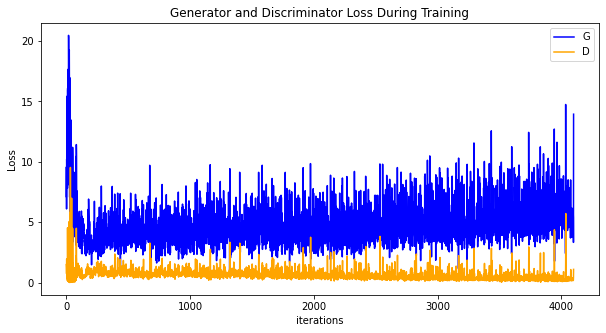

In [13]:
plt.figure(figsize=(10, 5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses, label="G", color='blue')
plt.plot(D_losses, label="D", color='orange')
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

可视化训练过程中通过隐向量`fixed_noise`生成的图像。

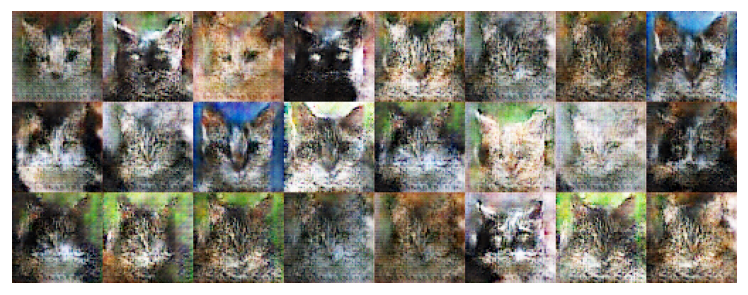

In [14]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation

def showGif(image_list):
    show_list = []
    fig = plt.figure(figsize=(8, 3), dpi=120)
    for epoch in range(len(image_list)//10):
        images = []
        for i in range(3):
            row = np.concatenate((image_list[epoch*10][i * 8:(i + 1) * 8]), axis=1)
            images.append(row)
        img = np.clip(np.concatenate((images[:]), axis=0), 0, 1)
        plt.axis("off")
        show_list.append([plt.imshow(img)])

    ani = animation.ArtistAnimation(fig, show_list, interval=500, repeat_delay=1000, blit=True)
    ani.save('./my_dcgan_animal_nz200_ep100.gif', writer='pillow', fps=1)

showGif(image_list)

In [15]:
# from mindspore import load_checkpoint
# from mindvision import dataset

# dl_path = "./netG"
# dl_url = "https://download.mindspore.cn/vision/classification/Generator.ckpt"

# dl = dataset.DownLoad()  # 下载Generator.ckpt文件
# dl.download_url(url=dl_url, path=dl_path)

# # 从文件中获取模型参数并加载到网络中
# param_dict = load_checkpoint("./netG/Generator.ckpt", netG)

# img64 = netG(fixed_noise).transpose(0, 2, 3, 1).asnumpy()

# fig = plt.figure(figsize=(8, 3), dpi=120)
# images = []
# for i in range(3):
#     images.append(np.concatenate((img64[i * 8:(i + 1) * 8]), axis=1))
# img = np.clip(np.concatenate((images[:]), axis=0), 0, 1)
# plt.axis("off")
# plt.imshow(img)
# plt.show()

# 实践总结
## 实验总结
这次实验中主要完成了分别使用人脸数据集和猫脸数据集训练DCGAN网络生成人脸图片和猫脸图片，调试超参数，修改网络结构。生成的人脸图片和猫脸图片具体效果如下所示：

![cat-faces-1](./images/cat-face-2.gif)

参数设置：

| net | DCGAN |
| -----|-----|
| nz      | 100 |
| epoch      | 100       |

![cat-faces-2](./images/dcgan_animal.gif)

参数设置：

| net | DCGAN |
| -----|-----|
| nz      | 150 |
| epoch      | 200       |

![cat-faces-3](./images/dcgan_animal_nz200_ep200.gif)

参数设置：

| net | DCGAN |
| -----|-----|
| nz      | 200 |
| epoch      | 200       |

![cat-faces-4](./images/my_dcgan_animal_nz200_ep100.gif)

参数设置：

| net | DCGAN(增加层数) |
| -----|-----|
| nz      | 200 |
| epoch      | 100       |

![human-faces-1](./images/dcgan.gif)

参数设置：

| net | DCGAN |
| -----|-----|
| nz      | 100 |
| epoch      | 100       |

![human-faces-2](./images/human-face-1.gif)

参数设置：

| net | DCGAN |
| -----|-----|
| nz      | 100 |
| epoch      | 200       |

上方GIF为迭代中固定高斯噪声输入到生成器中生成的图片。

对比猫脸和人脸的生成效果，从中能够看出，猫脸生成效果比人脸生成效果好，原因可能为：
1. 人脸数据集相对猫脸数据集较少
2. 人脸隐向量维数设置较低，部分维度的信息可能没有生成出来
3. 人脸可能比猫脸更复杂，更难学习

对比不同隐向量维度下猫脸的生成效果，从中能够看出，隐向量维度较高生成出的猫脸效果更好，原因可能为：
1. 隐空间设置为较低的维，生成的图像质量不行，原因在于隐空间的这个维度编码的不只是数字类型，它应该还有包含其他信息。数字类型是离散的，测度为0，不会充满整一维的空间，而其他信息一般是连续的，测度大于0，多种信息交织不完整地编码在低维度空间中，导致生成图像与真实图像有一定差距。

另外在训练中发现，隐空间维数也不能太高，太高了占用太多显存，模型更强，搜索空间更大，存在更多的鞍点，学的越慢。

在增加了网络结构的卷积层层数后，模型的生成器和判别器在训练过程中产生的震荡比原始模型更大，原因还有待探究。

|![output1.png](./images/output1.png) |![output2.png](./images/output2.png) |
|----|----|
|DCGAN网络|My_DCGAN网络|
